In [19]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors
from matplotlib import ticker, cm
%matplotlib notebook
import emcee
import pickle

In [26]:
with open('times_some.pickle', 'rb') as f:
    data_new = pickle.load(f)
    
lengths = np.array([50, 75, 100, 150, 200, 250, 300, 350, 400 ])

eps = np.array([0,5,10,12,13])/10


<IPython.core.display.Javascript object>


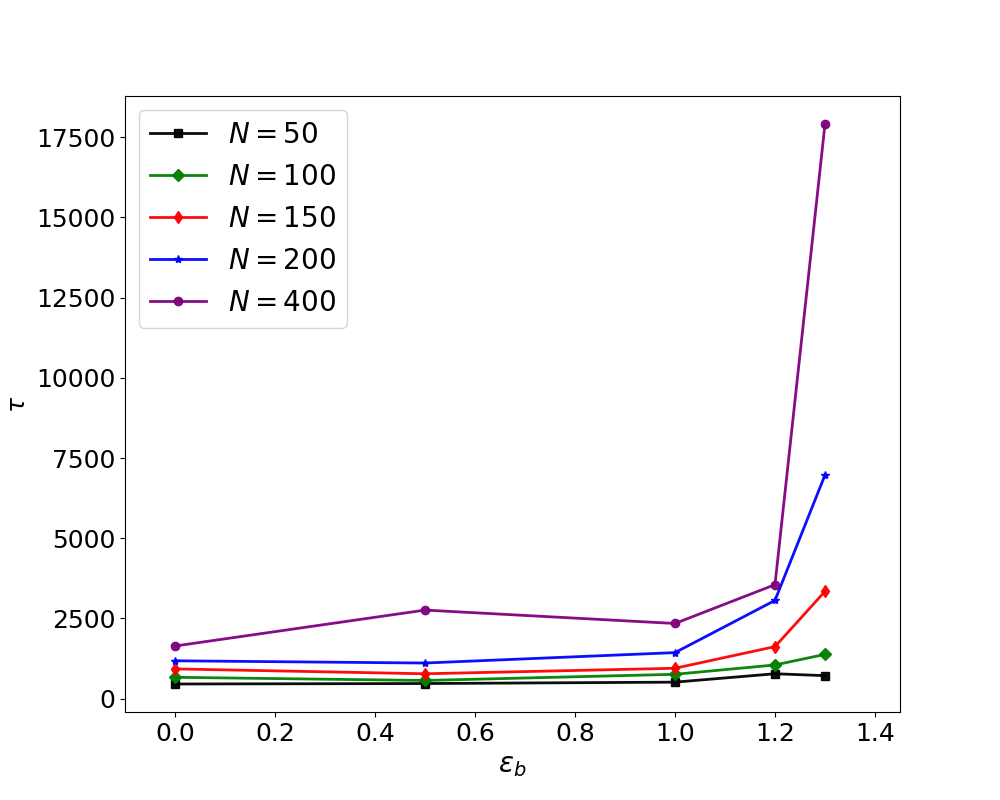

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)


plt.plot(eps,  data_new[0,:-1], "s-", label=r"$N=50$", c="k",lw=2, alpha=0.95)
plt.plot(eps,  data_new[1,:-1], "D-", label=r"$N=100$", c="g",lw=2, alpha=0.95)
plt.plot(eps,  data_new[2,:-1], "d-", label=r"$N=150$", c="r",lw=2, alpha=0.95)
plt.plot(eps,  data_new[3,:-1], "*-", label=r"$N=200$", c="b",lw=2, alpha=0.95)

plt.plot(eps,  data_new[7,:-1], "o-", label=r"$N=400$", c="purple",lw=2, alpha=0.95)





plt.xlabel(r"$\epsilon_b$", fontsize = 20)
plt.ylabel( r"$\tau$" , fontsize=18)

plt.tick_params(axis='x', labelsize=18) 
plt.tick_params(axis='y', labelsize=18) 

plt.xlim(-0.1, 1.45)

plt.legend(loc="best", fontsize=20)

plt.savefig("/home/kamilla/SAWs/Bachelor thesis/img/autocorrs.png")


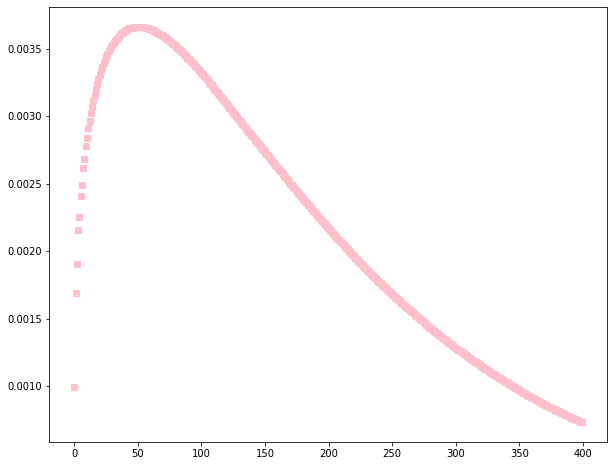

In [16]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)


counts = np.loadtxt("HP_simulations/Main_Simulations/counts_hp_moresteps_0.000000_higher_hpc.txt", skiprows=6, dtype=int) 
sums = np.zeros(np.max(counts[:,0])+1)
for i in counts:
    sums[i[0]] = sums[i[0]] + i[2]
plt.plot(np.arange(np.max(counts[:,0])+1)[:400],  sums[:400]/np.sum(counts[:,2]), "s", c = "pink", lw=9, label = r"$\beta=0.370093$ ($\langle N \rangle \approx 55.2262$)")



In [4]:
with open('/home/kamilla/Downloads/times3.pickle', 'rb') as f:
    data_new = pickle.load(f)

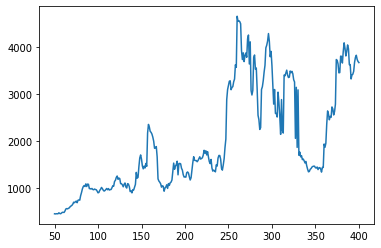

In [5]:
data_new = data_new[:-1]


plt.plot(np.arange(50,401), data_new)

In [9]:
with open('/home/kamilla/Downloads/times7.pickle', 'rb') as f:
    data_new = pickle.load(f)
    
data_new[50]

749.8869900659781

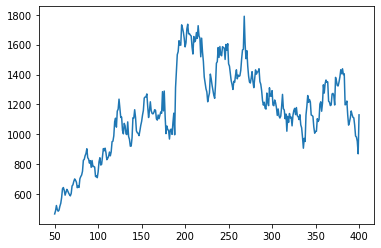

In [8]:
data_new = data_new[:-1]


plt.plot(np.arange(50,401), data_new)

In [6]:
import emcee


def log_prob(p):
    return np.logaddexp(-0.5 * np.sum(p ** 2), -0.5 * np.sum((p - 4.0) ** 2))


sampler = emcee.EnsembleSampler(32, 3, log_prob)
sampler.run_mcmc(
    np.concatenate((np.random.randn(16, 3), 4.0 + np.random.randn(16, 3)), axis=0),
    5000,
    progress=True,
);

 73%|███████▎  | 3656/5000 [00:03<00:01, 1035.24it/s]


KeyboardInterrupt: 

In [66]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

In [70]:
chain = sampler.get_chain()[:, :, 0].T
chain

array([[ 0.47025365,  0.47025365, -0.12750713, ...,  3.87144555,
         3.83430852,  4.69604539],
       [-0.98597007, -0.98597007, -0.98597007, ...,  1.03283665,
         0.88363034,  0.77849451],
       [ 0.55319254,  0.31463318, -0.58701075, ...,  3.90641136,
         3.90641136,  3.90641136],
       ...,
       [ 4.22919606,  4.6248553 ,  4.5068056 , ...,  3.6617437 ,
         3.59665427,  3.27715531],
       [ 3.91594008,  3.91594008,  3.91594008, ..., -0.49035305,
        -0.49035305, -0.49035305],
       [ 6.19519988,  5.65625769,  5.65625769, ...,  5.36957514,
         5.36957514,  5.36957514]])

32
(32, 100)
32
(32, 88)
32
(32, 77)
32
(32, 68)
32
(32, 60)
32
(32, 53)
32
(32, 46)
32
(32, 41)
32
(32, 36)
32
(32, 32)


<IPython.core.display.Javascript object>


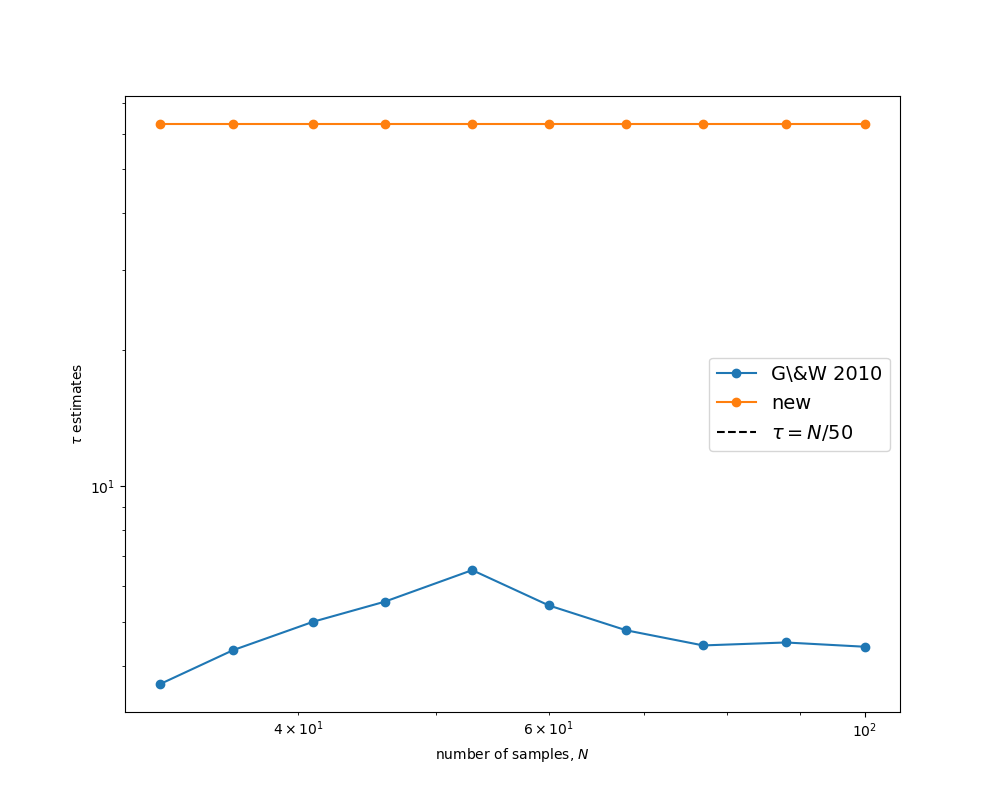

63.0

In [69]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    
    f = autocorr_func_1d(np.mean(y, axis=0))
 
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    #print(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
 
    print(len(y))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

#N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[0]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])
    print( chain[:, :n].shape)
    #gw2010[i] = autocorr_gw2010(chain[:n])
    #new[i] = autocorr_new(chain[:n])
    
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
new[-1]

In [1]:
for i in range(5,6):
    filename = "/home/kamilla/SAWs/Autocorrs/lengths_hp_moresteps_"+str(i/10)+"00000_higher_hpc.bin"
    #currentdata = np.genfromtxt(file, max_rows = 6, missing_values = "" )
    filedata = np.loadtxt(filename ) 

NameError: name 'np' is not defined

In [8]:
chain =filedata

In [ ]:
emcee.autocorr.integrated_time(chain, c=200, quiet=True)

In [12]:
toplot = emcee.autocorr.function_1d(chain)

<IPython.core.display.Javascript object>


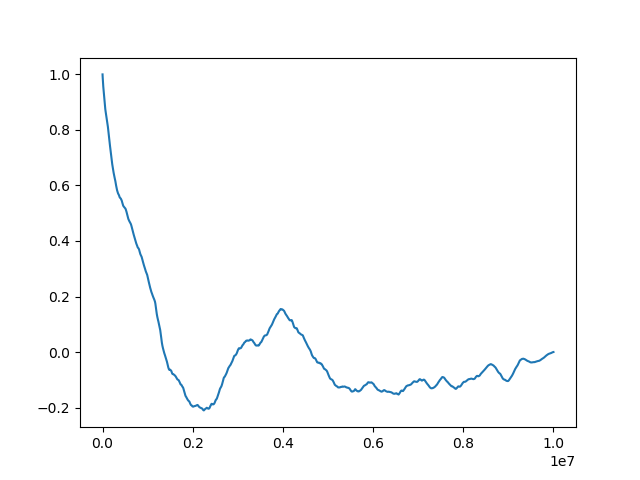

In [13]:
plt.plot(toplot)

In [44]:
gw2010

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       1.2518596e-317, 4.4465903e-317])

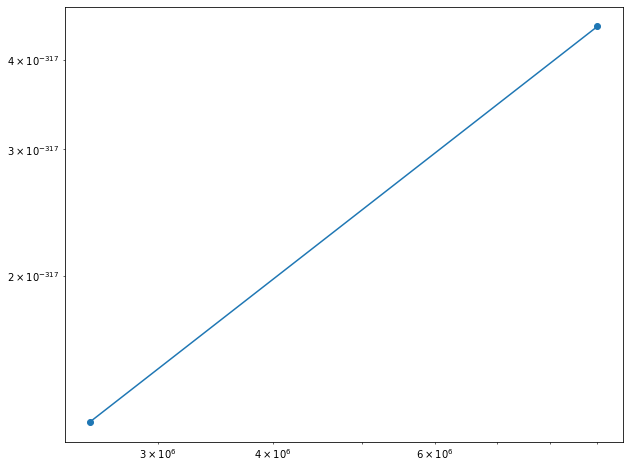

In [45]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")

In [64]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    
    f = autocorr_func_1d(np.mean(y, axis=0))
 
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[0])
    #print(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

#N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[0]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    #gw2010[i] = autocorr_gw2010(chain[:, :n])
    #new[i] = autocorr_new(chain[:, :n])
    gw2010[i] = autocorr_gw2010(chain[:n] )
    new[i] = autocorr_new(chain[:n] )
    
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
#plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

ValueError: operands could not be broadcast together with shapes (32,) (5000,) (32,) 

In [48]:
filedata

array([125., 125., 124., ..., 495., 496., 496.])

In [49]:
from scipy.optimize import minimize


def autocorr_ml(y, thin=1, c=5.0):
    # Compute the initial estimate of tau using the standard method
    init = autocorr_new(y, c=c)
    z = y[:, ::thin]
    N = z.shape[1]

    # Build the GP model
    tau = max(1.0, init / thin)
    kernel = terms.RealTerm(
        np.log(0.9 * np.var(z)), -np.log(tau), bounds=[(-5.0, 5.0), (-np.log(N), 0.0)]
    )
    kernel += terms.RealTerm(
        np.log(0.1 * np.var(z)),
        -np.log(0.5 * tau),
        bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
    )
    gp = celerite.GP(kernel, mean=np.mean(z))
    gp.compute(np.arange(z.shape[1]))

    # Define the objective
    def nll(p):
        # Update the GP model
        gp.set_parameter_vector(p)

        # Loop over the chains and compute likelihoods
        v, g = zip(*(gp.grad_log_likelihood(z0, quiet=True) for z0 in z))

        # Combine the datasets
        return -np.sum(v), -np.sum(g, axis=0)

    # Optimize the model
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, bounds=bounds)
    gp.set_parameter_vector(soln.x)

    # Compute the maximum likelihood tau
    a, c = kernel.coefficients[:2]
    tau = thin * 2 * np.sum(a / c) / np.sum(a)
    return tau


# Calculate the estimate for a set of different chain lengths
ml = np.empty(len(N))
ml[:] = np.nan
for j, n in enumerate(N[1:8]):
    i = j + 1
    thin = max(1, int(0.05 * new[i]))
    ml[i] = autocorr_ml(chain[:, :n], thin=thin)


ValueError: cannot convert float NaN to integer

In [17]:
import acor

ModuleNotFoundError: No module named 'acor'